# Contents

* [How to use mtSet from command line](mtSet_scripts.ipynb)
    * [Preprocessing](mtSet_preprocess.ipynb)
    * [Phenotype Simulator](mtSet_phenosim.ipynb)
    * [Running mtSet](mtSet_analyze.ipynb)
    * [Postprocessing](mtSet_postprocess.ipynb)
    * [Example for command line usage](example_usage.ipynb)
* [How to use mtSet within python](mtSet_python.ipynb)

#How to use mtSet within python

This tutorial shows how to use mtSet within python. For a tutorial on how to use mtSet from the command line using the limix scripts (mtSet_preprocess, mtSet_analyze, mtSet_postprocess, mtSet_simPheno) please refer to the tutorials:
* [Tutorial on how to use mtSet from command line](mtSet_scripts.ipynb)
* [Example for command line usage](example_usage.ipynb)

## Setting up

In [2]:
# activiate inline plotting
%matplotlib inline

from setup import get_1000G_mtSet
import scipy as sp
import scipy.linalg
import limix

In [3]:
# loading 1000G genotypes for mtSet demo
get_1000G_mtSet()

File ./../data/1000g/chrom22_subsample20_maf0.10.bed exsits
File ./../data/1000g/chrom22_subsample20_maf0.10.bim exsits
File ./../data/1000g/chrom22_subsample20_maf0.10.fam exsits
File ./../data/1000g/pheno.phe exsits
File ./../data/1000g/chrom22.cov exsits


In [4]:
# base name for bed, bim and fam
bfile = './../data/1000g/chrom22_subsample20_maf0.10'

## Split genotypes into regions

In [5]:
from limix.mtSet.core import plink_reader

In [6]:
# import genotype positions
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
chrom = bim[:, 0].astype(float)
pos = bim[:, -1].astype(float)

In [7]:
# uses splitter to split the genotypes
from limix.mtSet.core.splitter import Splitter
split = Splitter(pos=pos,chrom=chrom)

The method _splitGeno_ allows to define the regions that will then considered for the analysis with mtSet.
Information relative to the calculated regions can be cached in an external file by activating the cache option (see below).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _method_      | 'slidingWindow' | str | Uses a sliding window approach to define regions (a region-based approach will be availabe soon) |
| _size_      | 5E+04 (50kb) | float | Window size. Pace is set at half the size of the window |
| _minSnps_      | 1 | int | Windows with number of SNPs lower that this threshold are not considered |
| _maxSnps_      | sp.inf | int | Windows with number of SNPs higher that this threshold are not considered |
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [8]:
split.splitGeno(cache=True, fname='regions.h5', minSnps=4)
print '%d windows' % split.nWindows

1380 windows


## Apply mtSet

In this paragraph we showcase how to construct the mtSet class that will then be used for the set test analysis.
We showcase both the full mtSet that models relatedness as random effect by the means of an individual-to-individual covariance matrix and the approximated model (mtSetPC) that models relatedness as fixed effect using principal component from the covariance.

In [9]:
# import phenotype and sample relatedness
pheno_file = './../data/1000g/pheno.phe'
sample_relatedness_file = './../data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)
R = sp.loadtxt(sample_relatedness_file)

In [10]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
S_R, U_R = scipy.linalg.eigh(R) # these are needed for the full mtSet model

In [11]:
# caculate fixed effects with rel
F = U_R[:, ::-1][:, :10] # it considered the first 10 PCs
F = sp.concatenate([F, sp.ones((F.shape[0], 1))], 1) # add an intercept term

In [12]:
if 0:
    # use full mtSet implementation
    # (relatedness is modeled as random effect by the means of
    # an individual-to-individual covariance matrix)
    mtSet = limix.MTSet(Y, S_R=S_R, U_R=U_R)
else:
    # use mtSetPC
    # (relatedness s modelled as fixed effect
    # using principal component from the covariance)
    mtSet = limix.MTSet(Y, F=F)

### Null model

If the analysis is parallelized across different set of regions and permutations,
it might be convenient to cache the results from the optimization of the null model
(as the null model need to be optimized only once).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| _cache_       | False | bool | If true, it activates the caching |
| _out_dir_     | './cache' | str | outdir of the cache file |
| _fname_       | None | str | Name of the file |
| _rewrite_     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [13]:
RV = mtSet.fitNull()

The returned dictionary contains:
* B: value of the optimized effect sizes
* Cg: value of the genetic trait-to-trait covariance
* Cn: value of the residual trait-to-trait covariance
* conv: bool that indicates convergence of the optimization
* time: time elpased for optimizing the parameters
* NLL0: negative log likelihood of the null model
* LMLgrad: norm of the gradient of the negative log likelihood dividived by the number of parameters

### Test

In [14]:
# read fam
bim = plink_reader.readBIM(bfile,usecols=(0,1,2,3))
fam = plink_reader.readFAM(bfile,usecols=(0,1))

In [15]:
n_wnds = 100 # only hundred windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions
for wnd_i in range(n_wnds):
    wnd_pos = split.wnd_pos[wnd_i]
    nSnps = split.nSnps[wnd_i]
    idx_wnd_start = split.idx_wnd_start[wnd_i]
    print '.. window %d - (%d, %d-%d) - %d snps' % (wnd_i, wnd_pos[0], wnd_pos[1], wnd_pos[2], nSnps)
    
    Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']

    # multi trait set test fit
    RV = mtSet.optimize(Xr)
    LLR[wnd_i] = RV['LLR'][0]

.. window 0 - (22, 16025000-16075000) - 21 snps
.. window 1 - (22, 16050000-16100000) - 23 snps
.. window 2 - (22, 16125000-16175000) - 7 snps
.. window 3 - (22, 16225000-16275000) - 9 snps
.. window 4 - (22, 16250000-16300000) - 16 snps
.. window 5 - (22, 16275000-16325000) - 12 snps
.. window 6 - (22, 16325000-16375000) - 5 snps
.. window 7 - (22, 16350000-16400000) - 5 snps
.. window 8 - (22, 16475000-16525000) - 8 snps
.. window 9 - (22, 16500000-16550000) - 7 snps


The returned dictionary from _mtSet.optimize_ contains:
* Cr: value of the region-term trait-to-trait covariance
* Cg: value of the genetic trait-to-trait covariance
* Cn: value of the residual trait-to-trait covariance
* variances: n_traits-by-3 matrix of variance explained by the three contributions (region, background, noise) for the  traits
* conv: bool that indicates convergence of the optimization
* time: time elpased for optimizing the parameters
* NLLAlt: negative log likelihood of the alternative model
* LLR: test statistics
* LMLgrad: norm of the gradient of the negative log likelihood dividived by the number of parameters

### P-values

P values are obtained from a relatively small number of genome-wide permutations, fitting a parametric model to the null distribution. Here we showcase the permutation procedure by considering 10 permutations for the 10 regions analyzed.

In [16]:
n_perms = 10
LLR_null = [] # in this list test statistics from permutations will be stored
for perm_i in range(n_perms):
    
    #1. generate permutation
    print 'permutation %d' % perm_i
    sp.random.seed(perm_i)
    perm_idxs = sp.random.permutation(Y.shape[0])
    
    #2. scan on the 100 regions
    for wnd_i in range(n_wnds):
        wnd_pos = split.wnd_pos[wnd_i]
        nSnps = split.nSnps[wnd_i]
        idx_wnd_start = split.idx_wnd_start[wnd_i]
        Xr = plink_reader.readBED(bfile, useMAFencoding=True, start = idx_wnd_start, nSNPs = nSnps, bim=bim , fam=fam)['snps']
        Xr = Xr[perm_idxs, :] # permute samples in region term
        RV = mtSet.optimize(Xr)
        LLR_null.append(RV['LLR'][0])
LLR_null = sp.array(LLR_null)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


The parametric fit to the ditribution of the test statistics under the null and the consequent conversion of the observed test statistics in P values is performed by the module _limix.stats.chi2mixture_ as shown below.

In [19]:
from limix.stats.chi2mixture import Chi2mixture
c2m = Chi2mixture(tol=4e-3)
c2m.estimate_chi2mixture(LLR_null)
pv = c2m.sf(LLR)

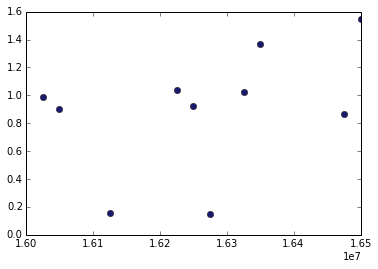

In [26]:
#makes a manhattan plot
wnd_chrom = split.wnd_pos[:n_wnds,0]
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(pv), 'o', color='MidnightBlue')